In [1]:
from sentence_transformers import SentenceTransformer
from pymilvus import connections,utility,Collection,CollectionSchema, FieldSchema,DataType
from langchain.vectorstores import Milvus
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from sentence_transformers import models

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from typing import Literal, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_model(model_name='airesearch/wangchanberta-base-att-spm-uncased', max_seq_length=768, condition=True):
    if condition:
        # model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
        # model_name = "hkunlp/instructor-large"
        word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='cls') # We use a [CLS] token as representation
        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    return model

In [3]:
connections.connect(host="localhost",port="19530")

# model = get_model(model_name="intfloat/multilingual-e5-large", max_seq_length=768)
model = get_model(model_name='airesearch/wangchanberta-base-att-spm-uncased', max_seq_length=768)
# model = get_model(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", max_seq_length=768)



In [4]:
## Define the fields that would go into the schema 
item_id = FieldSchema(
  name="id",
  dtype=DataType.INT64,
  is_primary=True,
  auto_id=True
)

## you need to provide max_length
text = FieldSchema(
  name="text",
  dtype=DataType.VARCHAR,
  max_length= 50000

)

## one float_vector field mandatory ?
embeddings = FieldSchema(
  name="embeddings",
  dtype=DataType.FLOAT_VECTOR,
  dim=768
)
## define collection schema 
schema = CollectionSchema(
  fields=[item_id, text, embeddings],
  description="Search clinical trial docs",
  enable_dynamic_field=True
)

## define the collection
collection = Collection(
    name="leave_policy_th",
    schema=schema,
    using='default'
    )


In [5]:
def split_text_with_overlap(text, chunk_size, overlap_size):
    chunks = []
    start_index = 0

    while start_index < len(text):
        end_index = start_index + chunk_size
        chunk = text[start_index:end_index]
        chunks.append(chunk)
        start_index += (chunk_size - overlap_size)

    return chunks

# english = open("assets/text/leave_policy_EN.txt", encoding="utf8").read()
thai = open("assets/text/leave_policy_TH.txt", encoding="utf8").read()

texts = split_text_with_overlap(thai, 600, 60)

In [6]:
embeds = [list(embed) for embed in model.encode(texts)]
print("no of embeddings ", len(embeds))  ## no of embeddings 
print("dim of each embedding ", len(embeds[0])) ## dim of each embedding

no of embeddings  20
dim of each embedding  768


In [7]:
collection.insert([texts,embeds])
collection.create_index(field_name="embeddings",\
                        index_params={"metric_type":"IP","index_type":"IVF_FLAT","params":{"nlist":16384}})



Status(code=0, message=)

In [8]:
# พนักงานปกติจะได้รับวันลากี่วัน แล้วใช่ยังไง
# ถ้าหากว่าฉันจะต้องการลา พักร้อนต้องทำอะไรบ้าง
# ถ้าปีนี้ผมลาไม่ครบ ผมจะเอาวันลาไปใช่ปีหน้าได้ไหม แล้วกี่วัน
# ลาคลอดได้รับเงินไหม แล้วลาได้นานแค่ไหน

query = "ลาคลอดได้รับเงินไหม แล้วลาได้นานแค่ไหน"
query_encode = [list(i) for i in model.encode([query])]
collection = Collection('leave_policy_th')
collection.load()
documents = collection.search(data=query_encode, anns_field="embeddings", param={"metric":"IP","offset":0},
                  output_fields=["text"], limit=4)

print("no. of retrieved docs", len(documents[0]))

i = 1
for doc in documents[0]:
    # print(doc[0].text)
    print(f'doc {i}: \n', doc.text, "\n")
    i += 1


no. of retrieved docs 4
doc 1: 
 ่ได้รับ
พนักงานต้องยื่นคำร้องขอลาพักร้อนที่ได้รับล่วงหน้า 15 วัน หลังจากยื่นคำร้องแล้ว การแจ้งเตือนจะถูกส่งไปยังผู้จัดการที่รับผิดชอบโดยตรง เมื่อการลาได้รับการอนุมัติ การแจ้งเตือนจะถูกส่งไปยังพนักงานและแผนกทรัพยากรบุคคล ยอดคงเหลือหลังจากการหักลาจะได้รับการปรับปรุงในระบบ HRMS

ลาคลอด
• พนักงานหญิงที่ได้รับการยืนยันสถานะทั้งหมดจะมีสิทธิ์ได้รับการลาคลอดตามพระราชบัญญัติสวัสดิการการคลอดปี 2016 พร้อมกับค่าจ้างเต็มจำนวนสำหรับระยะเวลา 26 สัปดาห์ติดต่อกัน (ไม่รวมวันหยุดนักขัตฤกษ์) สำหรับการตั้งครรภ์แต่ละครั้งสูงสุด 2 ครั้ง
• การลาที่ใช้เพื่อการรักษาก่อนคลอดในช่วง 7 เดือนแรกของการตั้งครรภ์จะถือว่าเป็นกา 

doc 2: 
 ่ได้รับ
พนักงานต้องยื่นคำร้องขอลาพักร้อนที่ได้รับล่วงหน้า 15 วัน หลังจากยื่นคำร้องแล้ว การแจ้งเตือนจะถูกส่งไปยังผู้จัดการที่รับผิดชอบโดยตรง เมื่อการลาได้รับการอนุมัติ การแจ้งเตือนจะถูกส่งไปยังพนักงานและแผนกทรัพยากรบุคคล ยอดคงเหลือหลังจากการหักลาจะได้รับการปรับปรุงในระบบ HRMS

ลาคลอด
• พนักงานหญิงที่ได้รับการยืนยันสถานะทั้งหมดจะมีสิทธิ์ได้รับการลาคลอดตาม

In [9]:
## drop the collection, everything is lost.
utility.drop_collection("leave_policy_th")

## Visualizing distance

In [10]:
def visualize_embeddings(embeddings_2d: np.ndarray, 
                         question: Optional[bool] = False, 
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 384-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 384) containing the embeddings.
        question (numpy.array, optional): An additional 384-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings_2d[:-1].shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
        
    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 384-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

In [11]:
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_with_question = np.vstack([model.encode(texts), query_encode])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

In [12]:
embeddings_2d.shape

(21, 2)

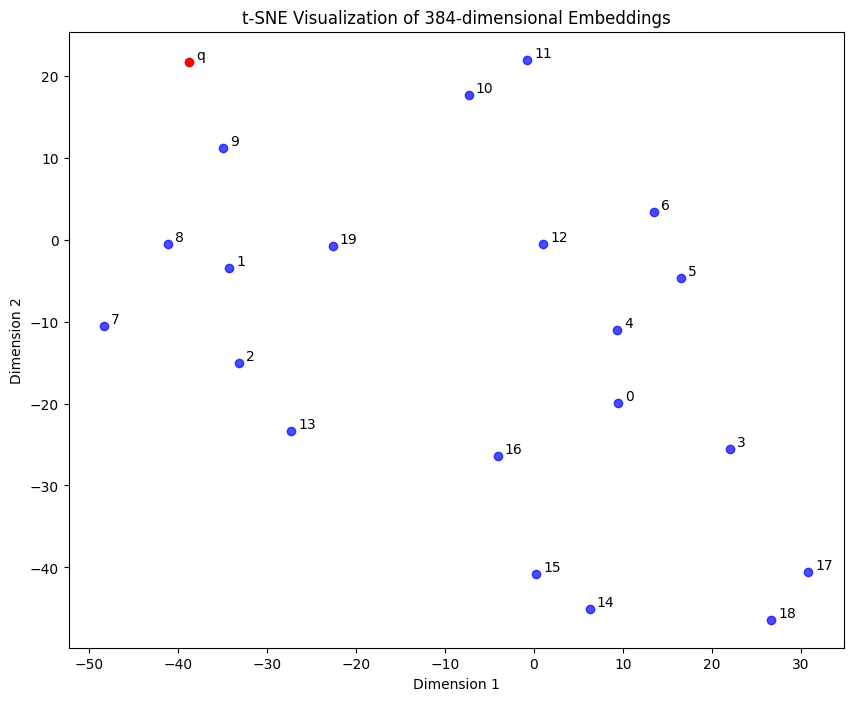

In [13]:
visualize_embeddings(embeddings_2d=embeddings_2d, question=True)

In [14]:
print(texts[9])

่ได้รับ
พนักงานต้องยื่นคำร้องขอลาพักร้อนที่ได้รับล่วงหน้า 15 วัน หลังจากยื่นคำร้องแล้ว การแจ้งเตือนจะถูกส่งไปยังผู้จัดการที่รับผิดชอบโดยตรง เมื่อการลาได้รับการอนุมัติ การแจ้งเตือนจะถูกส่งไปยังพนักงานและแผนกทรัพยากรบุคคล ยอดคงเหลือหลังจากการหักลาจะได้รับการปรับปรุงในระบบ HRMS

ลาคลอด
• พนักงานหญิงที่ได้รับการยืนยันสถานะทั้งหมดจะมีสิทธิ์ได้รับการลาคลอดตามพระราชบัญญัติสวัสดิการการคลอดปี 2016 พร้อมกับค่าจ้างเต็มจำนวนสำหรับระยะเวลา 26 สัปดาห์ติดต่อกัน (ไม่รวมวันหยุดนักขัตฤกษ์) สำหรับการตั้งครรภ์แต่ละครั้งสูงสุด 2 ครั้ง
• การลาที่ใช้เพื่อการรักษาก่อนคลอดในช่วง 7 เดือนแรกของการตั้งครรภ์จะถือว่าเป็นกา


In [15]:
embeddings_2d[:-1].shape[0]

20

## Using Langchain
you can also leverage langchain and Milvus.
Documentation - https://python.langchain.com/docs/integrations/vectorstores/milvus